In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
from __future__ import division

import argparse
import tqdm
import numpy as np

from terminaltables import AsciiTable

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from pytorchyolo.models import load_model

In [3]:
model_path = "./Data/Models/Config/yolov3-tiny.cfg"
weights_path = "./Data/Models/Weights/yolov3-tiny.weights"

In [4]:
model = load_model(model_path, weights_path)
model = model.to(torch.device("mps"))

In [5]:
img = np.random.randn(1, 3, 427, 640)
img = torch.tensor(img, dtype=torch.float32, device="mps")
print(img.dtype)

torch.float32


In [6]:
output = model(img)
for x in output:
    print(x.shape)

torch.Size([1, 3, 13, 20, 85])
torch.Size([1, 3, 26, 40, 85])


In [7]:
from torch.utils import data

In [8]:
import os
from PIL import Image


class CocoDetection(data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.


    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """


    def __init__(self, root, annFile, transform=None, target_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform


    def __getitem__(self, index):
        """
        Args:
            index (int): Index


        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)


        path = coco.loadImgs(img_id)[0]['file_name']


        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)


        if self.target_transform is not None:
            target = self.target_transform(target)


        return img, target




    def __len__(self):
        return len(self.ids)


    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [9]:
my_dataset = CocoDetection("./Data/COCO/val2017","./Data/COCO/annotations/captions_val2017.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [10]:
my_dataset[0]

(<PIL.Image.Image image mode=RGB size=640x427>,
 [{'image_id': 397133,
   'id': 370509,
   'caption': 'A man is in a kitchen making pizzas.'},
  {'image_id': 397133,
   'id': 370584,
   'caption': 'Man in apron standing on front of oven with pans and bakeware'},
  {'image_id': 397133,
   'id': 372252,
   'caption': 'A baker is working in the kitchen rolling dough.'},
  {'image_id': 397133,
   'id': 372765,
   'caption': 'A person standing by a stove in a kitchen.'},
  {'image_id': 397133,
   'id': 375891,
   'caption': 'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.'}])

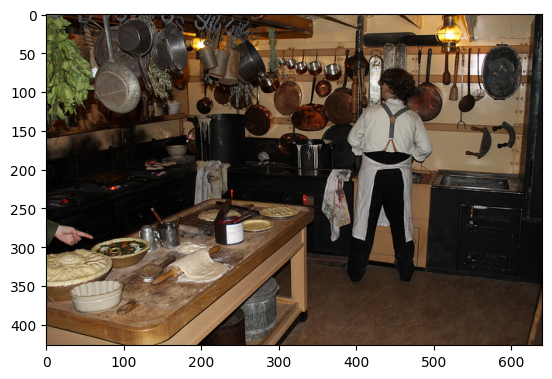

In [11]:
import matplotlib.pyplot as plt
plt.imshow(my_dataset[0][0])

In [12]:
from pytorchyolo.utils.transforms import PadSquare

img = my_dataset[0][0]
img = np.array(img)
print(img.shape)
img_numpy, _= PadSquare()([img, np.zeros((1,5))])
img = torch.tensor(img_numpy, dtype=torch.float32, device="mps")
img = img.transpose(0, 2).transpose(1, 2)
img = img[None, ...]
model.eval()
output = model(img)
print(img.shape)

(427, 640, 3)
torch.Size([1, 3, 640, 640])


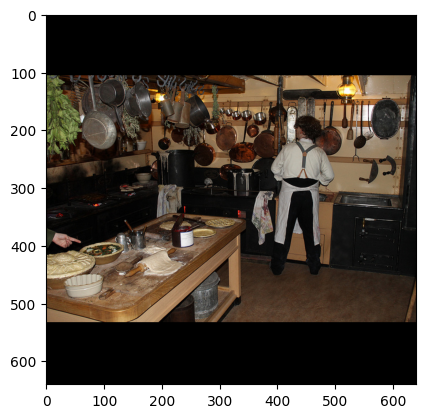

In [13]:
plt.imshow(img_numpy)

In [14]:
for x in output:
    print(x.shape)

torch.Size([6000, 85])


In [15]:
from pytorchyolo.utils.utils import rescale_boxes, load_classes, non_max_suppression
with torch.no_grad():
    outputs = model(img)
    print(outputs[0].shape)
    outputs = non_max_suppression(outputs, conf_thres=0.01, iou_thres=0.5)
    print(outputs[0].shape)
    #outputs is [max_number_bboxes, bbox+classspred+objred+label]
    #b_box = outputs[0, :, 0:4]
for x in outputs:
    print(x.shape)
#print(b_box.shape)
#print(b_box.max(), b_box.min())
print(outputs[0][:, 5].max())
print(outputs[0][:, 5].min())

torch.Size([6000, 85])
torch.Size([36, 6])
torch.Size([36, 6])
tensor(69.)
tensor(0.)


In [16]:
print(outputs[0][0])

tensor([401.2267, -72.2576, 512.8981, 812.2704,   0.9974,  67.0000])


In [17]:
with open("PyTorch-YOLOv3-master/data/coco.names", "r") as f:
    labels_list = f.readlines()
labels_list = [x.replace("\n", "") for x in labels_list]
print(labels_list)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [18]:
labels_bbox = []
for b_box in outputs[0]:
    labels_bbox.append(labels_list[int(b_box[5].item())])

/opt/anaconda3/envs/cocoloco/lib/python3.9/site-packages/torchvision/utils.py:224: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


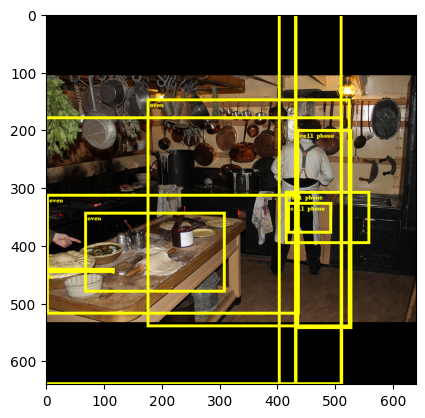

In [19]:
#YOLO Bounding Box Format is [x1, y1, x2, y2, confidence, class]
from torchvision.utils import draw_bounding_boxes
img_plot = img.cpu().detach().numpy()
img_plot = img_plot[0]
img_plot = torch.tensor(img_plot, dtype = torch.uint8)
#plt.imshow(img_plot/255)
boxes_toshow = 10
box_array = draw_bounding_boxes(img_plot, outputs[0][:boxes_toshow, 0:4], colors = "yellow", width= 5, labels= labels_bbox[0:boxes_toshow], font_size= 32)
box_array = box_array.numpy().transpose(1, 2, 0)
plt.imshow(box_array)


tensor(-11660.0312) tensor(513.5805)
tensor(-1082876.8750) tensor(1083132.3750)


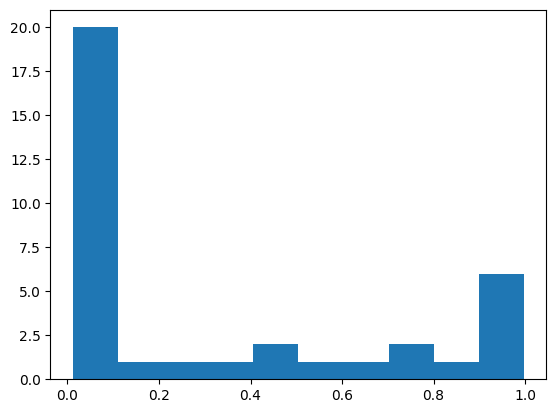

In [20]:
confidence = outputs[0][:, 4]
print(outputs[0][:, 1].min(), outputs[0][:, 1].max())
plt.hist(outputs[0][:, 4].cpu().numpy())
b_box_overthres = outputs[0][confidence>0, 0:4]
print(b_box_overthres.min(), b_box_overthres.max())

In [21]:
def bbox_validity_check(bbox_max, bbox_min, valid_range):
    if bbox_max>valid_range or bbox_min<0:
        return False
    return True

In [22]:
valid_bboxes = []
valid_bboxes_confidence = []
for b_box in outputs[0]:
    min_val = min(b_box[:2])
    max_val = max(b_box[2:4])
    if bbox_validity_check(max_val, min_val, 1400):
        valid_bboxes.append(b_box[:6].cpu().numpy())
        valid_bboxes_confidence.append(b_box[4].cpu().numpy())

(array([8., 1., 1., 0., 1., 1., 0., 2., 0., 3.]),
 array([0.01323525, 0.10746388, 0.20169252, 0.29592115, 0.39014977,
        0.48437843, 0.57860702, 0.67283571, 0.76706433, 0.86129296,
        0.95552158]),
 <BarContainer object of 10 artists>)

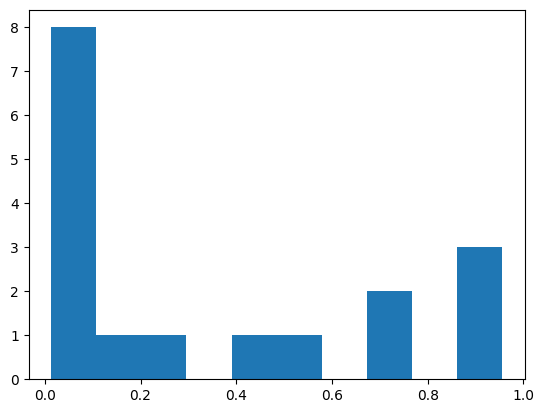

In [23]:
plt.hist(valid_bboxes_confidence)

In [24]:
valid_bboxes = torch.tensor(np.stack(valid_bboxes))
labels_bbox = []
for b_box in valid_bboxes:
    labels_bbox.append(labels_list[int(b_box[5].item())])

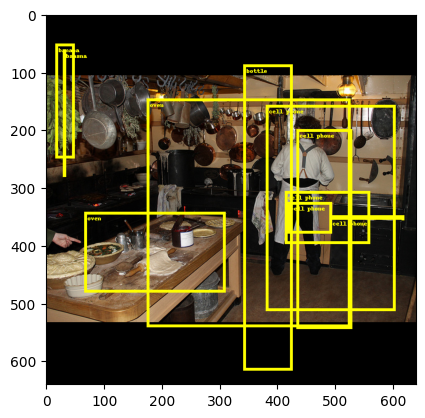

In [25]:
#YOLO Bounding Box Format is [x1, y1, x2, y2, confidence, class]
from torchvision.utils import draw_bounding_boxes
img_plot = img.cpu().detach().numpy()
img_plot = img_plot[0]
img_plot = torch.tensor(img_plot, dtype = torch.uint8)
#plt.imshow(img_plot/255)
boxes_toshow = 10
box_array = draw_bounding_boxes(img_plot, valid_bboxes[:boxes_toshow, 0:4], colors = "yellow", width= 5, labels= labels_bbox[0:boxes_toshow], font_size= 32)
box_array = box_array.numpy().transpose(1, 2, 0)
plt.imshow(box_array)